In [7]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
import re

import sklearn
from sklearn.pipeline import Pipeline

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer

from sklearn import metrics
import matplotlib.pyplot as plt
from datetime import datetime
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import StratifiedKFold
from xgboost import XGBClassifier
from collections import Counter
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve,scorer
from sklearn.metrics import f1_score
import statsmodels.api as sm
from sklearn.metrics import precision_score,recall_score
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.preprocessing import MinMaxScaler
import pickle as pkl

### Some USER DEFINED

In [8]:
# keep track of time of ALGO
def timer(start_time=None):
    if not start_time:
        start_time = datetime.now()
        return start_time
    elif start_time:
        thour, temp_sec = divmod((datetime.now() - start_time).total_seconds(), 3600)
        tmin, tsec = divmod(temp_sec, 60)
        print('\n Time taken: %i hours %i minutes and %s seconds.' % (thour, tmin, round(tsec, 2)))

def xgb_roc_auc_score(y, t):
    #
    # Function to evaluate the prediction based on F1 score, this will be used as evaluation metric when training xgboost model
    # Args:
    #   y: label
    #   t: predicted
    #
    # Return:
    #   f1: F1 score of the actual and predicted
    #
    t = t.get_label()
    y_bin = [1. if y_cont > 0.5 else 0. for y_cont in y]   # change the prob to class output
    return 'f1', roc_auc_score(t, y_bin)

####################################################
#  to load over  written models
# clf2 = pickle.loads(s)
####################################################

def metrics_ROC(model, X_test, modelname, y_test, y_prob):
    fpr, tpr, th = roc_curve(y_test, y_prob)
    
    plt.figure(1, figsize=(10, 7))
    plt.plot([0, 1], [0, 1], 'k--')
    plt.plot(fpr, tpr)
    
    plt.xlabel('False positive rate')
    plt.ylabel('True positive rate')
    
    plt.title(f'{modelname} - ROC curve - test')
    
    plt.show()
    optimal_idx = np.argmax(tpr - fpr)
    
    optimal_threshold = th[optimal_idx]
    
    y_pred = [1 if i >=optimal_threshold  else 0 for i in model.predict_proba(X_test)[:,1]]
    conf_matrix = pd.DataFrame(
        metrics.confusion_matrix(y_test, y_pred),
        columns=pd.MultiIndex(levels=[['Predicted'], 
                                      ['0', '1']], 
                              codes=[[0, 0], 
                                     [0, 1]]),
        index=pd.MultiIndex(levels=[['Actual'], 
                                    ['0', '1']], 
                            codes=[[0, 0], 
                                   [0, 1]]))
    
    
    print('AUC score: ',roc_auc_score(y_test, y_prob))
    print('Precision: ',precision_score(y_test, y_pred))
    print('Recall: ',recall_score(y_test, y_pred))
    print('Accuracy: ',accuracy_score(y_test, y_pred))
    print('F1 score: ',f1_score(y_test, y_pred))
    print('\n')
    print('Confusion Matrix:')
    display(conf_matrix)
    print('\n')
    print('Classification report:\n\n', metrics.classification_report(y_test, y_pred))

### Bypassing Feature Engineer  
saved locally the .csv of the two splittings


**for 1 hot**

- `train1.to_csv('tuo_path\\train1.csv', index = False)`
- `test1.to_csv('tuo_path\\test1.csv', index = False)`

**for mean_enc**

- `train2.to_csv('tuo_path\\train2.csv', index = False)`
- `test2.to_csv('tuo_path\\test2.csv', index = False)`

In [9]:
train1 = pd.read_csv('train1.csv')
test1 = pd.read_csv('test1.csv')
train1_x = train1.drop('Churn', axis = 1)
train1_y = train1['Churn']
test1_x = test1.drop('Churn', axis = 1)
test1_y = test1['Churn']

# random state
seed = 2020

# XBGOOST classifier  

> XGBoost is an optimized distributed gradient boosting library designed to be highly efficient, flexible and portable. It implements machine learning algorithms under the Gradient Boosting framework. XGBoost provides a parallel tree boosting (also known as GBDT, GBM) that solve many data science problems in a fast and accurate way. The same code runs on major distributed environment (Hadoop, SGE, MPI) and can solve problems beyond billions of examples.

## 3 _subclasses_  of parameters to get through:

- **General Parameters**: Guide the overall functioning `G`
- **Booster Parameters**: Guide the individual booster (tree/regression) at each step `B`
- **Learning Task Parameters**: Guide the optimization performed `L`

-------

## "Cross Validated"  approach:

Due to the big amount of parameters to search for we tried a side approach that will help us making the best choices in setting the parameters.
1. We tryed to enclose a grid of values one important parameter at a time given our dataset. This procedure was made by looking are the neg_log_loss and the selection of the candidates was made by elbow-method. 

2. These values selected were stored and then used in a Randomized Grid Search along with the less relevant parameters whose grid of values are wider. 

3. Present Results:
    1. through Feature Importance
    2. Accuracy
    3. AUC
    4. F1
    5. confusion matrix
    6. ROC curve 
    7. classification report
    
4. select the best model and make it perform 

5. evaluate the model performance and classfication and plot the final tree

## Important Paramteres inspected

- **n_estimators**  number of boosted trees to fit. To a point, more are better but will take more time.
- **max_depth** Maximum tree depth for base learners. Used to control overfitting.
- **learning_rate** learning rate is commonly set = 0.3 but in this case could be smaller due to the shape of the dataset
- **min_child_weight** Minimum sum of instance weight (hessian) needed in a child. Used to control over-fitting. Values that are too high can lead to under-fitting. If the classes are highly unbalanced, lower values (even 1) can be alright.
- **scale_pos_weight** Control the balance of positive and negative weights, useful for unbalanced classes, that is why upsampling is not used in this model. The unbalance issue can be sized by setting the parameter, as documentiation suggests equal to the ratio of negative values (majority) over the positive value (minority)

` contatore = Counter(train1_y)
stima = contatore[0] / contatore[1]` 

------

# Find a Right span  of VALUES OF n_estimators


### n_estimators:   


- for low medium dataset documentation suggest 1000 but at the same time it doesn not provide any reference to understand what is medium and what is low, so apparently we would say that it is purely low: I still perform a grid search in order to reduce the dimensionality of the parameter set 
- The total number of iterations is 200, composed by 20 times that 50 is in 1000 and then multiplied by 10, that comes from the 10 fold 
- The plot is helping us through the elbow criterion to fix the right number of trees: the output suggests 50, however the first derivative appears pretty similar one to each other, in the second part of the curve the log loss is flatter so we can discard them. so 50, 100, 150, 200, 250 are some reasonable choices 

[REF](https://books.google.it/books?id=HgmqDwAAQBAJ&pg=PA83&lpg=PA83&dq=plt.errorbar(n_estimators,+means,+yerr%3Dstds)&source=bl&ots=nLlFc4JbIz&sig=ACfU3U3CRHyOO4oGUhYvTpuNHKW48_Pcbw&hl=it&sa=X&ved=2ahUKEwiV1r6EqfrnAhXGyKYKHR8CCUwQ6AEwAHoECAoQAQ#v=onepage&q=plt.errorbar(n_estimators%2C%20means%2C%20yerr%3Dstds)&f=false)


----

# Find a Right span  of VALUES max_depth


### max_depth:   


- You should always control the depth of a tree, very shallow trees are expected to have poor performances because they capture few details of the problem and they refer as weak learners. Deeper trees as opposite are very likely to overfit data limiting the ability to make good predictions. Generally boosting algo are configured with weak learners, so decision trees with few layers, sometimes they are so simple that they contains only a node (same other parameter can trap the algo in that) those decision trees are called stumps.
- The number of iterations are now 5 times 10, so 50 
- Same considerations come with max_depth, the plot suggest to keep 3 values that are more associated with a decresing in the negative log loss function, these values are [3, 4, 5] 


------


# Find a Right span  of VALUES learning_rate


### learning_rate:   


- the leraning rate in this context controls the weighting of the new trees added to the model, it can also fasten the overrl algorythm but in the extreme cases can trap the algo in local minima or take a whole semester to output a value.
- The number of iterations are now 6 times 10, so 60 
- The plot shows a very clear parabolic pattern with a pick in 0.03 and 0.1. So here they are the candidates for the learning rate.


-----

### TOTAL NUMBER OF COMBINATIONS ARE NEARLY **233'000**

| min_child_weight | gamma | subsample | colsample_bytree | colsample_bylevel | max_depth |  scale_pos_weight | reg_lambda | learning_rate | n_estimators |  max_delta_step |
| --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- |
| [1, 3, 5] | [0, 0.25, 0.5, 1.0] | [0.8, 0.9, 1.0] | [0.6, 0.8, 0.9] | [0.7, 0.8, 0.9] |[3, 4, 5, 7] |[stima, 4] | [[10.0, 50.0, 100.0] | [0.1] | [50, 100, 200, 250]| [2, 3] |



-----------------

# Find a Right span  of VALUES OF N_ESTIMATORS 



### n_estimators:   


- for low medium dataset documentation suggest 1000 but at the same time it doesn not provide any reference to understand what is medium and what is low, so apparently I would say that it is totally low: I still perform a grid search on a single param in order to exclude it from being moved in following steps
- The total number of iterations is 200, composed by 20 times 50 in 1000 and then multiplied by 10, that comes from the 10 fold 
- as much as the number of tree will grow 
- The plot will help us through the elbow criterion to decide the right number of trees: the output suggests 50, howevere they are very similar one to each other, in the second part of the curve the log loss is flatter aka the first derivative associated is smaller. so 50, 100, 150, 200, 250 are some reasonable choices 


[REF](https://books.google.it/books?id=HgmqDwAAQBAJ&pg=PA83&lpg=PA83&dq=plt.errorbar(n_estimators,+means,+yerr%3Dstds)&source=bl&ots=nLlFc4JbIz&sig=ACfU3U3CRHyOO4oGUhYvTpuNHKW48_Pcbw&hl=it&sa=X&ved=2ahUKEwiV1r6EqfrnAhXGyKYKHR8CCUwQ6AEwAHoECAoQAQ#v=onepage&q=plt.errorbar(n_estimators%2C%20means%2C%20yerr%3Dstds)&f=false)

In [154]:
modello_num_est = XGBClassifier()
n_estimators = range(50, 1000, 50)
param_grid = dict(n_estimators=n_estimators)
kfolds = StratifiedKFold(n_splits=10, shuffle=True, random_state=seed)
grid_search = GridSearchCV(modello_num_est, 
                           param_grid, scoring="neg_log_loss",
                           n_jobs=4,
                           cv=kfolds,
                           verbose = 2)


grid_result = grid_search.fit(train1_x,train1_y )

Fitting 10 folds for each of 19 candidates, totalling 190 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:   14.9s


KeyboardInterrupt: 

Best: -0.438123 using {'n_estimators': 50}
-0.438123 (0.018958) with: {'n_estimators': 50}
-0.465997 (0.024052) with: {'n_estimators': 100}
-0.492300 (0.026787) with: {'n_estimators': 150}
-0.517301 (0.027656) with: {'n_estimators': 200}
-0.540796 (0.028900) with: {'n_estimators': 250}
-0.559809 (0.031445) with: {'n_estimators': 300}
-0.580954 (0.032638) with: {'n_estimators': 350}
-0.601852 (0.034298) with: {'n_estimators': 400}
-0.617044 (0.034408) with: {'n_estimators': 450}
-0.632803 (0.037354) with: {'n_estimators': 500}
-0.646946 (0.039778) with: {'n_estimators': 550}
-0.660129 (0.040233) with: {'n_estimators': 600}
-0.673273 (0.042308) with: {'n_estimators': 650}
-0.684371 (0.042959) with: {'n_estimators': 700}
-0.695861 (0.043835) with: {'n_estimators': 750}
-0.706762 (0.044866) with: {'n_estimators': 800}
-0.716272 (0.046656) with: {'n_estimators': 850}
-0.725086 (0.048125) with: {'n_estimators': 900}
-0.733854 (0.049304) with: {'n_estimators': 950}


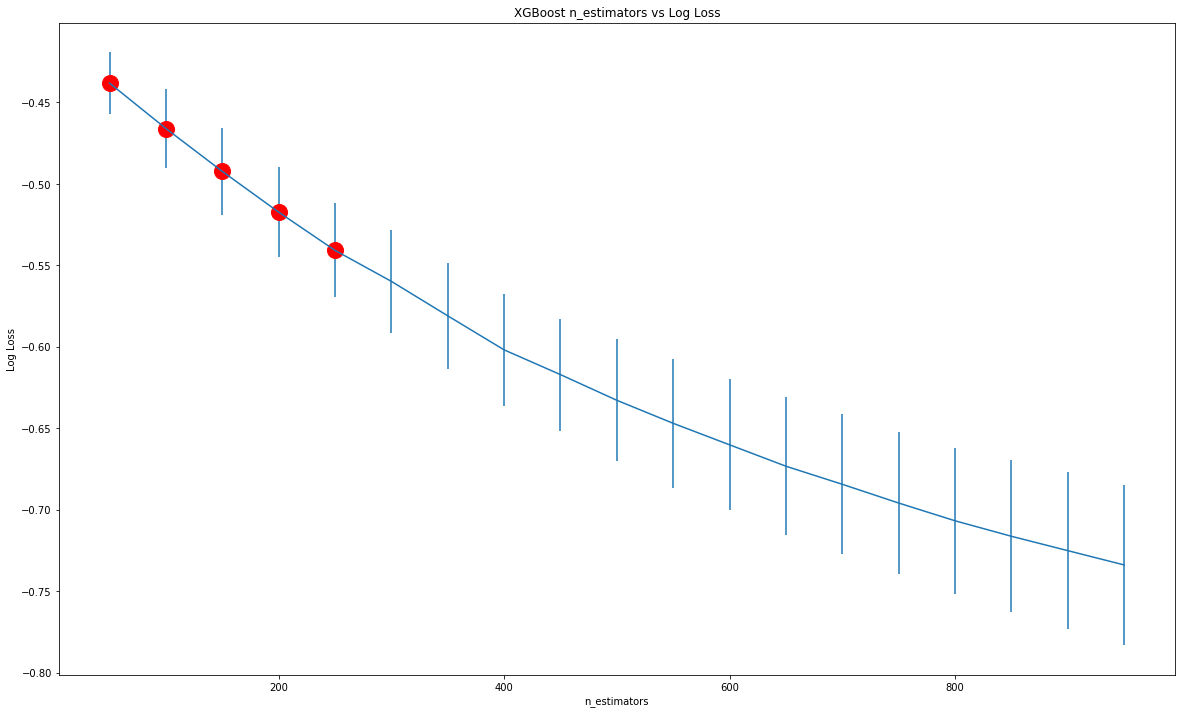

In [18]:
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

# plot
plt.figure(figsize = (20,12))
plt.errorbar(n_estimators, means, yerr=stds)
plt.title("XGBoost n_estimators vs Log Loss")
plt.xlabel('n_estimators')
plt.ylabel('Log Loss')
plt.plot([50], [-0.438123], marker='o', markersize=16, color="red")
plt.plot([100], [-0.465997], marker='o', markersize=16, color="red")
plt.plot([150], [-0.492300], marker='o', markersize=16, color="red")
plt.plot([200], [-0.517301], marker='o', markersize=16, color="red")
plt.plot([250], [-0.540796], marker='o', markersize=16, color="red")
plt.show()

# Find a Right span  of VALUES TREE_DEPTH


### tree_depth:   


- You should always control the depth of a tree, very shallow trees are expected to have poor performances because they capture few details of the problem and they refer as weak learners. Deeper trees as opposite are very likely to overfit data limiting the ability to make good predictions. Generally boosting algo are configured with weak learners, so decision trees with few layers, sometimes they are so simple that they contains only a node (this is a case in which some other paramters play a big role) those decision trees are called stumps.

- The number of iterations are now 5 times 10, so 50 
- Through the elbow criterion we can select also the right depth 

In [155]:
modello_max_dep = XGBClassifier()
max_depth = range(1, 11, 2)
param_grid1 = dict(max_depth=max_depth)
grid_search1 = GridSearchCV(modello_max_dep, 
                            param_grid1, 
                            scoring="neg_log_loss",
                            n_jobs=4,
                            cv=kfolds,
                            verbose = 4)


grid_result1 = grid_search1.fit(train1_x,train1_y )

Fitting 10 folds for each of 5 candidates, totalling 50 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  17 tasks      | elapsed:    4.6s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:   21.6s finished


Best: -0.408583 using {'max_depth': 1}
-0.408583 (0.011714) with: {'max_depth': 1}
-0.427556 (0.015063) with: {'max_depth': 3}
-0.452659 (0.019195) with: {'max_depth': 5}
-0.486409 (0.030158) with: {'max_depth': 7}
-0.530883 (0.028911) with: {'max_depth': 9}


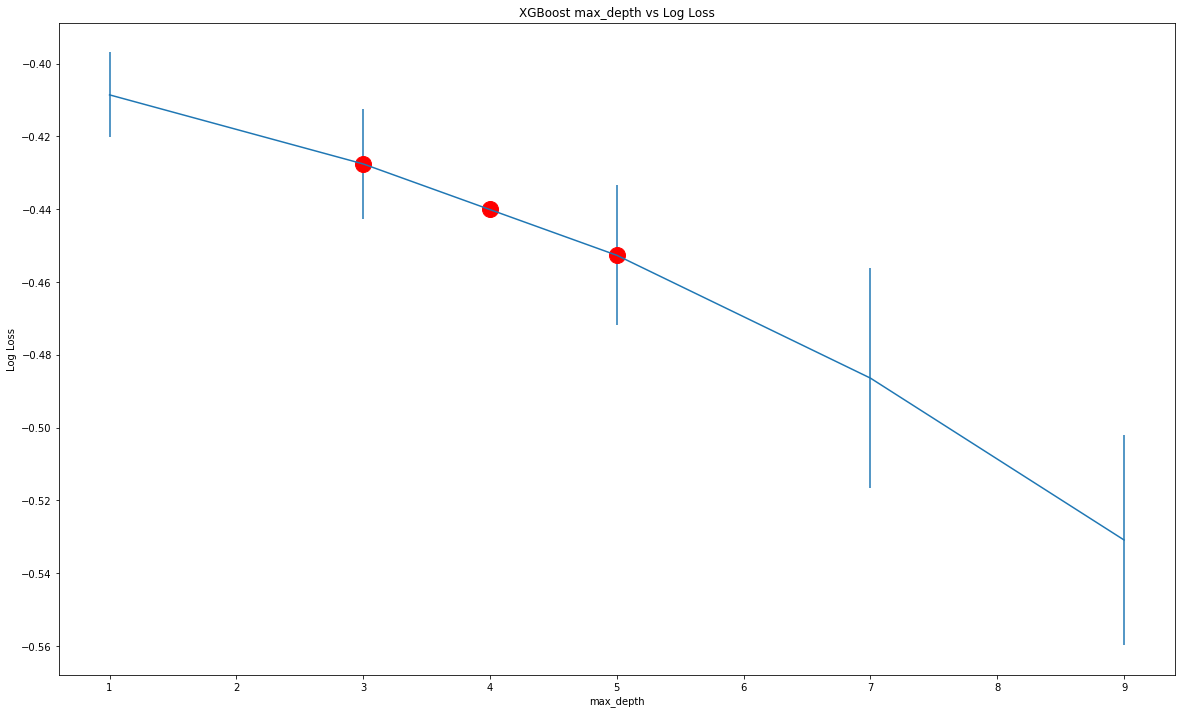

In [158]:
print("Best: %f using %s" % (grid_result1.best_score_, grid_result1.best_params_))
means1 = grid_result1.cv_results_['mean_test_score']
stds1 = grid_result1.cv_results_['std_test_score']
params1 = grid_result1.cv_results_['params']
for mean, stdev, param in zip(means1, stds1, params1):
    print("%f (%f) with: %r" % (mean, stdev, param))

# plot
plt.figure(figsize = (20,12))
plt.errorbar(max_depth, means1, yerr=stds1)
plt.title("XGBoost max_depth vs Log Loss")
plt.xlabel('max_depth')
plt.ylabel('Log Loss')
plt.plot([3], [-0.427556], marker='o', markersize=16, color="red")
plt.plot([5], [-0.452659], marker='o', markersize=16, color="red")
plt.plot([4], [-0.44], marker='o', markersize=16, color="red")

plt.show()

# Now combine them togheter to verify the neighbours highlighted before


### tree_depth and n_estimator :


- fewer boosted trees are required with increased tree depth. Further we would expect the increase complexitiy provided by deeper individual trees to result in greater overfitting of the training data that would be increased again by having more trees, determining a worst cross validation score.

- The number of iterations are now 3 times 7 times 10 = 210 
- This plot is willingly confusing and it does not provide a clear solution to the problem, however it suggests me to keep the full set of parameters, so I am starting to think that a RandomizedSearchCV is necessary.

red lines in the plot enclose the two parameter space to consider

In [150]:
max_dep_n_estim = XGBClassifier()
max_depth_tot = [3,4,5]
n_estimators_tot = range(50,400,50)
param_grid2 = dict(max_depth=max_depth_tot, n_estimators = n_estimators_tot)
grid_search2 = GridSearchCV(max_dep_n_estim, 
                            param_grid2,
                            scoring="neg_log_loss",
                            n_jobs=4,
                            cv=kfolds,
                            verbose = 2)


grid_result2 = grid_search2.fit(train1_x,train1_y )

Fitting 10 folds for each of 21 candidates, totalling 210 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.


KeyboardInterrupt: 

Best: -0.418945 using {'max_depth': 3, 'n_estimators': 50}
-0.418945 (0.013694) with: {'max_depth': 3, 'n_estimators': 50}
-0.427556 (0.015063) with: {'max_depth': 3, 'n_estimators': 100}
-0.433708 (0.017069) with: {'max_depth': 3, 'n_estimators': 150}
-0.443241 (0.018653) with: {'max_depth': 3, 'n_estimators': 200}
-0.451453 (0.018907) with: {'max_depth': 3, 'n_estimators': 250}
-0.460221 (0.019331) with: {'max_depth': 3, 'n_estimators': 300}
-0.466010 (0.019102) with: {'max_depth': 3, 'n_estimators': 350}
-0.421427 (0.014694) with: {'max_depth': 4, 'n_estimators': 50}
-0.436146 (0.018165) with: {'max_depth': 4, 'n_estimators': 100}
-0.448290 (0.021136) with: {'max_depth': 4, 'n_estimators': 150}
-0.461142 (0.024189) with: {'max_depth': 4, 'n_estimators': 200}
-0.473070 (0.025758) with: {'max_depth': 4, 'n_estimators': 250}
-0.486307 (0.029885) with: {'max_depth': 4, 'n_estimators': 300}
-0.497516 (0.029314) with: {'max_depth': 4, 'n_estimators': 350}
-0.431199 (0.015995) with: {'max_

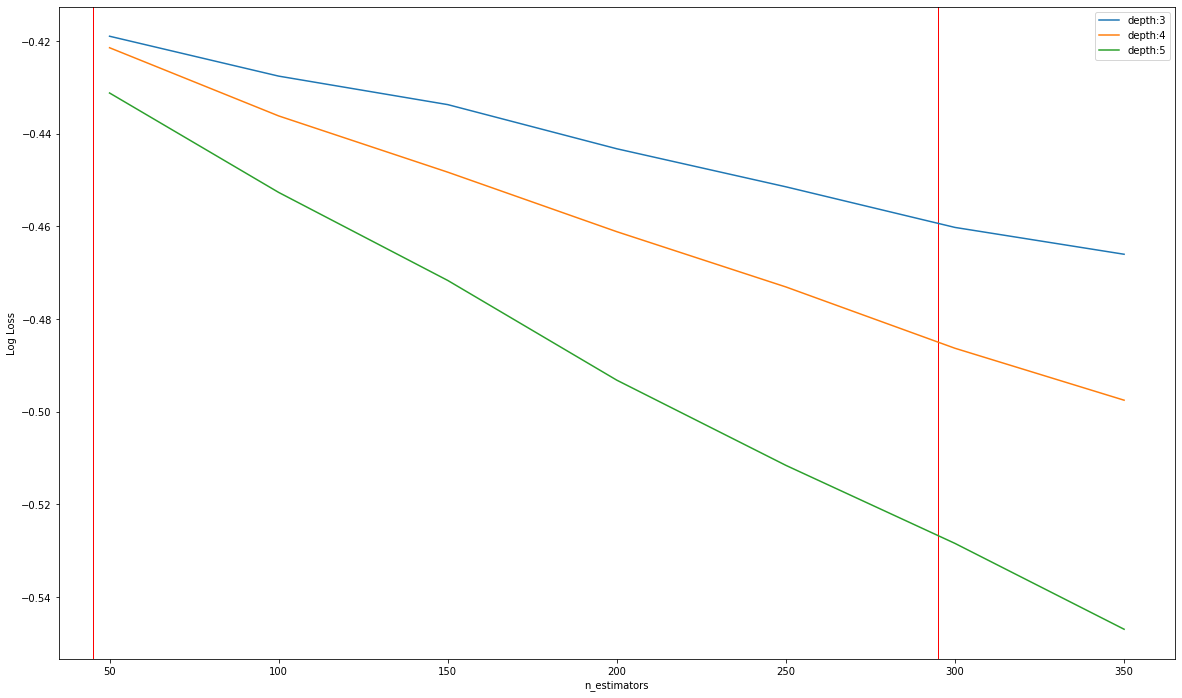

In [151]:
print("Best: %f using %s" % (grid_result2.best_score_, grid_result2.best_params_))
means2 = grid_result2.cv_results_['mean_test_score']
stds2 = grid_result2.cv_results_['std_test_score']
params2 = grid_result2.cv_results_['params']
for mean, stdev, param in zip(means2, stds2, params2):
    print("%f (%f) with: %r" % (mean, stdev, param))

# plotlen(n_tot))
plt.figure(figsize = (20,12))
scores = np.array(means2).reshape(len(max_depth_tot),len(n_estimators_tot))
for i, value in enumerate(max_depth_tot):
    plt.plot(n_estimators_tot, scores[i],label = 'depth:'+str(value))

plt.legend()
plt.xlabel('n_estimators')
plt.ylabel('Log Loss')
# plt.plot([50], [-0.418945], marker='o', markersize=16, color="red")
# plt.plot([100], [-0.427556 ], marker='o', markersize=16, color="red")
# plt.plot([150], [-0.433708], marker='o', markersize=16, color="red")
rectangle = plt.Rectangle((45,20), 250, -50, fc='white',ec="red")
plt.gca().add_patch(rectangle)
plt.show()

# Find a Right span  of LEARNING RATE


### learning_rate:   


- the leraning rate in this context controls the weighting of the new trees added to the model, so for this trial we will keep the number of trees n_estimator fixed 
- The number of iterations are now 6 times 10, so 60 
- Through the elbow criterion we can select also the right depth 

In [56]:
modello_l_rate = XGBClassifier()
l_rate = [0.001, 0.01, 0.03, 0.1, 0.3, 0.9]
param_grid3 = dict(learning_rate = l_rate )
grid_search3 = GridSearchCV(modello_l_rate, 
                            param_grid3,
                            scoring="neg_log_loss",
                            n_jobs=4,
                            cv=kfolds,
                            verbose = 3)


grid_result3 = grid_search3.fit(train1_x,train1_y)

Fitting 10 folds for each of 6 candidates, totalling 60 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:   10.7s
[Parallel(n_jobs=4)]: Done  60 out of  60 | elapsed:   26.0s finished


Best: -0.420090 using {'learning_rate': 0.03}
-0.652340 (0.000744) with: {'learning_rate': 0.001}
-0.479410 (0.005740) with: {'learning_rate': 0.01}
-0.420090 (0.011862) with: {'learning_rate': 0.03}
-0.426186 (0.016427) with: {'learning_rate': 0.1}
-0.465997 (0.024052) with: {'learning_rate': 0.3}
-0.691149 (0.041801) with: {'learning_rate': 0.9}


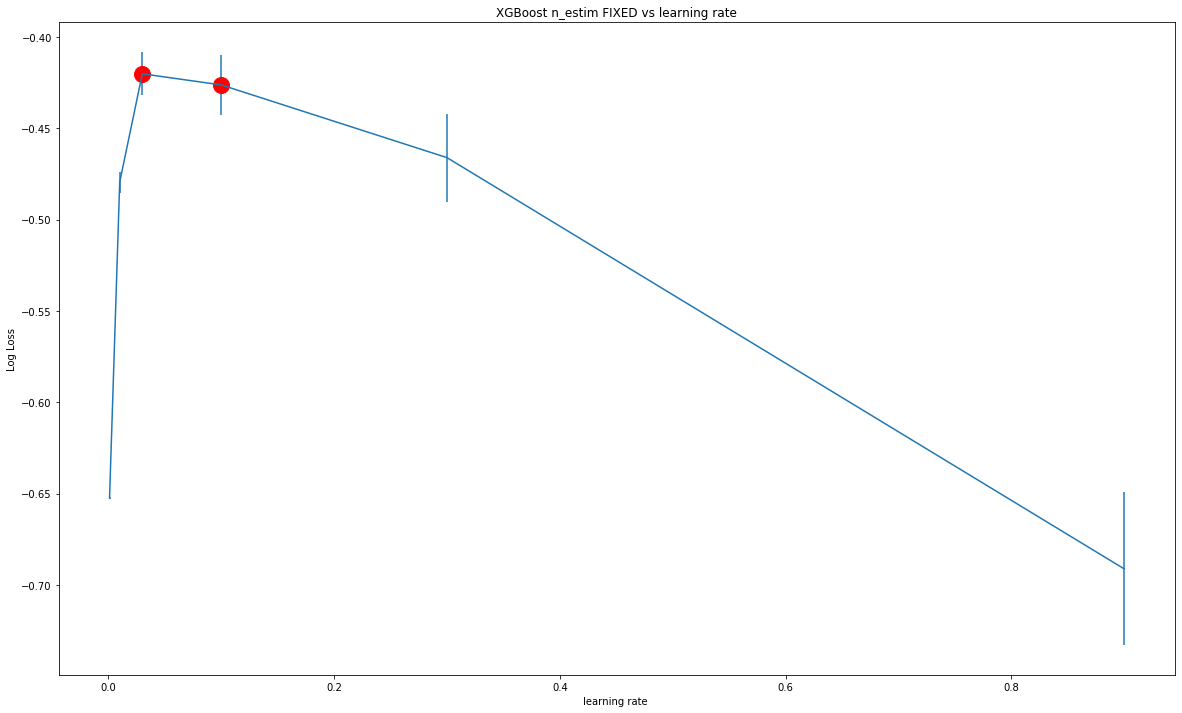

In [58]:
print("Best: %f using %s" % (grid_result3.best_score_, grid_result3.best_params_))
means3 = grid_result3.cv_results_['mean_test_score']
stds3 = grid_result3.cv_results_['std_test_score']
params3 = grid_result3.cv_results_['params']
for mean, stdev, param in zip(means3, stds3, params3):
    print("%f (%f) with: %r" % (mean, stdev, param))


plt.figure(figsize = (20,12))
plt.errorbar(l_rate, means3, yerr=stds3)
plt.title("XGBoost n_estim FIXED vs learning rate")
plt.xlabel('learning rate ')
plt.ylabel('Log Loss')
plt.plot([0.03], [-0.420090 ], marker='o', markersize=16, color="red")
plt.plot([0.1], [ -0.426186], marker='o', markersize=16, color="red")
plt.show()

# XGBOOST One Hot (train1)

- tentativo con parametri crossvalidati sui modelli di prima
- XGBOOST is a special  Decision Trees an it does not require normalization of their inputs; and since XGBoost is essentially en ensemble algorithm comprised of Decision Trees, it does not require normalization for the inputs either [REF](https://github.com/dmlc/xgboost/issues/357)

TOTAL NUMBER OF COMBINATIONS ARE NEARLY **233'000**

## Parameter Space:

| min_child_weight | gamma | subsample | colsample_bytree | colsample_bylevel | max_depth |  scale_pos_weight | reg_lambda | learning_rate | n_estimators |  max_delta_step |
| --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- |
| [1, 3, 5] | [0, 0.25, 0.5, 1.0] | [0.8, 0.9, 1.0] | [0.6, 0.8, 0.9] | [0.7, 0.8, 0.9] |[3, 4, 5, 7] |[stima, 4] | [[10.0, 50.0, 100.0] | [0.1] | [50, 100, 200, 250]| [2, 3] |


In [109]:
def results(cv):
    parameters = cv.cv_results_['params']
    table = pd.DataFrame.from_dict(parameters)
    table['mean_train_score'] = cv.cv_results_['mean_train_score']
    table['mean_test_score'] = cv.cv_results_['mean_test_score']
    
    return table

def rgrid_search_wrapper(pipeline, parameters):
    
    rand_grid_search = RandomizedSearchCV(pipeline, 
                                     parameters, 
                                     cv=5,
                                     random_state= seed,
                                     scoring='roc_auc',
                                     verbose=3,
                                     return_train_score=True,
                                     n_iter=10000,
                                     n_jobs=4)
    rand_grid_search.fit(train1_x,train1_y)
   
    return rand_grid_search   

In [140]:
# questo serve da mettere come valore del parametro: "scale_pos_weight"
contatore = Counter(train1_y)
stima = contatore[0] / contatore[1] # best estimate according to books
stima

2.762541806020067

In [111]:
# XGBOOST is a special  Decision Trees does not require normalization of their inputs; and since XGBoost is
# essentially en ensemble algorithm comprised of Decision Trees, it does not require normalization for the inputs either

xgb_pipeline = Pipeline([
                            ('scaler', MinMaxScaler(feature_range=(-1,1))),
                            ('xgb_model', XGBClassifier()),
                    ])
params_all = {
        'xgb_model__min_child_weight': [1, 3, 5],
        'xgb_model__gamma': [0, 0.25, 0.5, 1.0],
        'xgb_model__subsample': [0.8, 0.9, 1.0],
        'xgb_model__colsample_bytree': [0.6, 0.8, 0.9],
        'xgb_model__colsample_bylevel': [0.7, 0.8, 0.9],
        'xgb_model__max_depth': [3, 4, 5, 7],
        'xgb_model__scale_pos_weight ': [stima, 4],
        'xgb_model__reg_lambda': [10.0, 50.0, 100.0],
        'xgb_model__learning_rate':[0.1], 
        'xgb_model__n_estimators':[50, 100, 200, 250],
        'xgb_model__max_delta_step': [2, 3],
        'xgb_model__objective' :['binary:logistic']
        }

In [112]:
grid_search_XGBClassifier = rgrid_search_wrapper(xgb_pipeline, params_all)

Fitting 5 folds for each of 10000 candidates, totalling 50000 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:    6.5s
[Parallel(n_jobs=4)]: Done 120 tasks      | elapsed:   31.0s
[Parallel(n_jobs=4)]: Done 280 tasks      | elapsed:  1.5min
[Parallel(n_jobs=4)]: Done 504 tasks      | elapsed:  2.9min
[Parallel(n_jobs=4)]: Done 792 tasks      | elapsed:  4.6min
[Parallel(n_jobs=4)]: Done 1144 tasks      | elapsed:  6.7min
[Parallel(n_jobs=4)]: Done 1560 tasks      | elapsed:  9.1min
[Parallel(n_jobs=4)]: Done 2040 tasks      | elapsed: 12.0min
[Parallel(n_jobs=4)]: Done 2584 tasks      | elapsed: 15.7min
[Parallel(n_jobs=4)]: Done 3192 tasks      | elapsed: 19.2min
[Parallel(n_jobs=4)]: Done 3864 tasks      | elapsed: 23.5min
[Parallel(n_jobs=4)]: Done 4600 tasks      | elapsed: 27.8min
[Parallel(n_jobs=4)]: Done 5400 tasks      | elapsed: 33.1min
[Parallel(n_jobs=4)]: Done 6264 tasks      | elapsed: 38.7min
[Parallel(n_jobs=4)]: Done 7192 tasks      | elapsed: 44.3min


In [115]:
results(grid_search_XGBClassifier)

,xgb_model__subsample,xgb_model__scale_pos_weight,xgb_model__reg_lambda,xgb_model__objective,xgb_model__n_estimators,xgb_model__min_child_weight,xgb_model__max_depth,xgb_model__max_delta_step,xgb_model__learning_rate,xgb_model__gamma,xgb_model__colsample_bytree,xgb_model__colsample_bylevel,mean_train_score,mean_test_score
0,1.0,2.762542,10.0,binary:logistic,100,1,4,2,0.1,0.50,0.9,0.8,0.896882,0.848649
1,0.9,2.762542,10.0,binary:logistic,50,3,7,3,0.1,0.00,0.6,0.7,0.908349,0.847430
2,1.0,2.762542,10.0,binary:logistic,50,1,7,3,0.1,0.50,0.6,0.9,0.916937,0.846553
3,1.0,2.762542,10.0,binary:logistic,100,3,7,2,0.1,0.00,0.9,0.7,0.939394,0.842317
4,1.0,2.762542,50.0,binary:logistic,100,1,3,3,0.1,0.25,0.9,0.7,0.871777,0.849443
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,1.0,2.762542,10.0,binary:logistic,250,5,3,3,0.1,0.00,0.6,0.9,0.895953,0.846645
9996,1.0,2.762542,100.0,binary:logistic,200,5,3,2,0.1,0.50,0.9,0.9,0.876270,0.849959
9997,1.0,2.762542,50.0,binary:logistic,250,5,7,3,0.1,0.50,0.9,0.8,0.928042,0.841112
9998,0.9,4.000000,10.0,binary:logistic,250,1,5,3,0.1,1.00,0.9,0.8,0.946432,0.839341


In [10]:
# fit best model 

best_model = XGBClassifier(objective = 'binary:logistic',
                         min_child_weight = 1,
                         gamma = 0.50,
                         subsample = 1.0,
                         colsample_bytree = 0.9,
                         colsample_bylevel = 0.8,
                         max_depth = 4,
                         reg_lambda = 10.0,
                         learning_rate = 0.1,
                         n_estimators = 100,
                         max_delta_step = 2,
                         silent = False,
                         n_jobs = 4
                        )

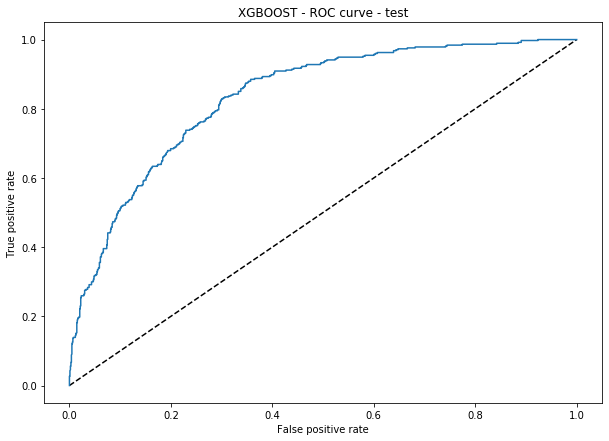

AUC score:  0.8337677498175192
Precision:  0.5
Recall:  0.8288770053475936
Accuracy:  0.7341862117981521
F1 score:  0.6237424547283702


Confusion Matrix:


Predicted     
                 0    1
Actual 0       723  310
       1        64  310



Classification report:

               precision    recall  f1-score   support

           0       0.92      0.70      0.79      1033
           1       0.50      0.83      0.62       374

    accuracy                           0.73      1407
   macro avg       0.71      0.76      0.71      1407
weighted avg       0.81      0.73      0.75      1407



In [11]:
best_model.fit(train1_x,train1_y)
y_prob = [train1_y for train1_x,train1_y in best_model.predict_proba(test1_x)]
metrics_ROC(best_model, test1_x, 'XGBOOST',  test1_y, y_prob)

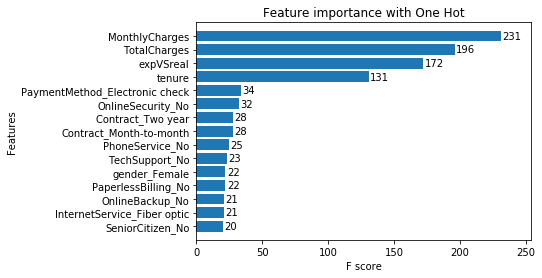

In [12]:
# this value is the number of times a feature appears in a tree
from xgboost import plot_importance
plot_importance(best_model,
                max_num_features = 15,
                height = 0.8,
                grid = False,
                title = 'Feature importance with One Hot')
plt.show()

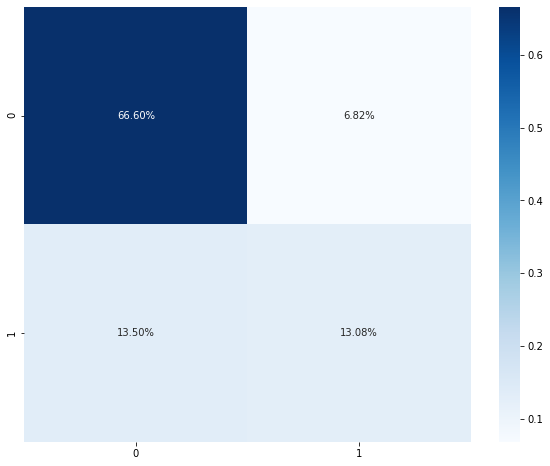

In [13]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
predizioni_best = best_model.predict(test1_x)
plt.figure(figsize = (10,8))
cm = confusion_matrix(test1_y, predizioni_best)
sns.heatmap(cm/np.sum(cm), annot=True, 
            fmt='.2%', cmap='Blues')
plt.show()


# Requirements:
to run this is mandatory to install **Graphviz** both locally by pip install and in the C folder, [HERE](https://graphviz.gitlab.io/_pages/Download/Download_windows.html) the link to install it.

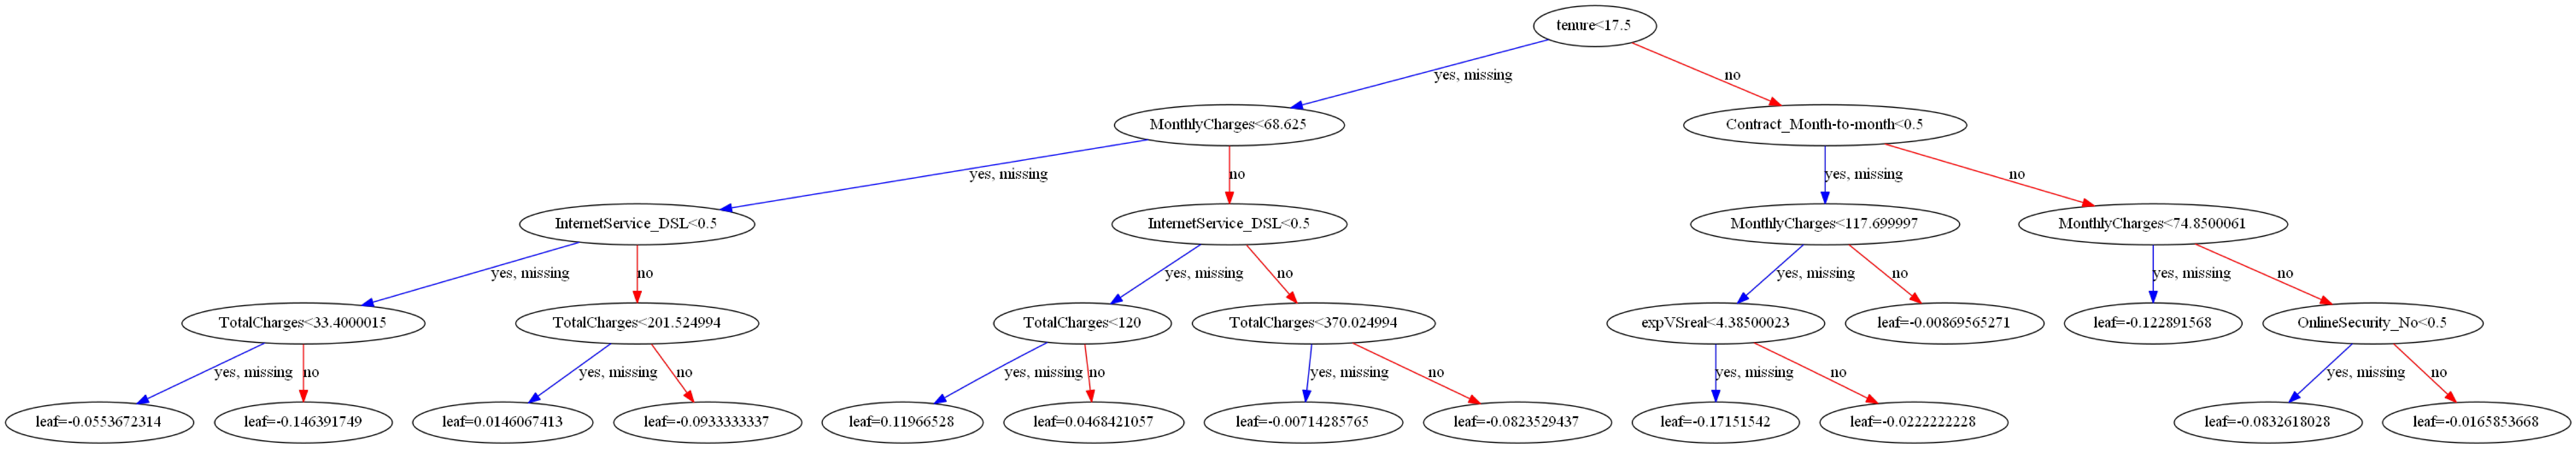

In [15]:
# final tree plot.
from xgboost import plot_tree
import graphviz
import os
os.environ["PATH"] += os.pathsep + 'C:/Program Files (x86)/Graphviz2.38/bin/'

plot_tree(best_model, num_trees = 0)
fig = plt.gcf()
fig.set_size_inches(300, 400)

# XGBOOST Mean_Enc (train2)

- tentativo su parametri crossvalidati sui modelli di prima
- XGBOOST is a special  Decision Trees an it does not require normalization of their inputs; and since XGBoost is essentially en ensemble algorithm comprised of Decision Trees, it does not require normalization for the inputs either [REF](https://github.com/dmlc/xgboost/issues/357)

TOTAL NUMBER OF COMBINATIONS ARE NEARLY **233'000**

| min_child_weight | gamma | subsample | colsample_bytree | colsample_bylevel | max_depth |  scale_pos_weight | reg_lambda | learning_rate | n_estimators |  max_delta_step |
| --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- |
| [1, 3, 5] | [0, 0.25, 0.5, 1.0] | [0.8, 0.9, 1.0] | [0.6, 0.8, 0.9] | [0.7, 0.8, 0.9] |[3, 4, 5, 7] |[stima, 4] | [[10.0, 50.0, 100.0] | [0.1] | [50, 100, 200, 250]| [2, 3] |


In [175]:
train2 = pd.read_csv('train2.csv')
test2 = pd.read_csv('test2.csv')
train2_x = train2.drop('Churn', axis = 1)
train2_y = train2['Churn']
test2_x = test2.drop('Churn', axis = 1)
test2_y = test2['Churn']

In [178]:
def results(cv):
    parameters = cv.cv_results_['params']
    table = pd.DataFrame.from_dict(parameters)
    table['mean_train_score'] = cv.cv_results_['mean_train_score']
    table['mean_test_score'] = cv.cv_results_['mean_test_score']
    
    return table
def rgrid_search_wrapper_mean(pipeline, parameters):
    
    rand_grid_search_mean = RandomizedSearchCV(pipeline, 
                                     parameters, 
                                     cv=5,
                                     random_state= seed,
                                     scoring='roc_auc',
                                     verbose=3,
                                     return_train_score=True,
                                     n_iter=5000,
                                     n_jobs=4)
    rand_grid_search_mean.fit(train2_x,train2_y)
   
    return rand_grid_search_mean   

In [179]:
# questo serve da mettere come valore del parametro: "scale_pos_weight"
contatore = Counter(train1_y)
stima = contatore[0] / contatore[1] # best estimate according to books
# I shuld not change the train set from 1 to 2 because the partition keeps the ration betweemn 0 and 1

In [180]:
# XGBOOST is a special  Decision Trees does not require normalization of their inputs; and since XGBoost is
# essentially en ensemble algorithm comprised of Decision Trees, it does not require normalization for the inputs either

params_all = {
        'xgb_model__min_child_weight': [1, 3, 5],
        'xgb_model__gamma': [0, 0.25, 0.5, 1.0],
        'xgb_model__subsample': [0.8, 0.9, 1.0],
        'xgb_model__colsample_bytree': [0.6, 0.8, 0.9],
        'xgb_model__colsample_bylevel': [0.7, 0.8, 0.9],
        'xgb_model__max_depth': [3, 4, 5, 7],
        'xgb_model__scale_pos_weight ': [stima, 4],
        'xgb_model__reg_lambda': [10.0, 50.0, 100.0],
        'xgb_model__learning_rate':[0.1], 
        'xgb_model__n_estimators':[50, 100, 200, 250],
        'xgb_model__max_delta_step': [2, 3],
        'xgb_model__objective' :['binary:logistic']
        }

In [181]:
grid_search_XGBClassifier_mean = rgrid_search_wrapper_mean(xgb_pipeline, params_all)

Fitting 5 folds for each of 5000 candidates, totalling 25000 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:    2.1s
[Parallel(n_jobs=4)]: Done 120 tasks      | elapsed:   16.5s
[Parallel(n_jobs=4)]: Done 280 tasks      | elapsed:   49.6s
[Parallel(n_jobs=4)]: Done 504 tasks      | elapsed:  1.7min
[Parallel(n_jobs=4)]: Done 792 tasks      | elapsed:  2.8min
[Parallel(n_jobs=4)]: Done 1144 tasks      | elapsed:  4.2min
[Parallel(n_jobs=4)]: Done 1560 tasks      | elapsed:  5.8min
[Parallel(n_jobs=4)]: Done 2040 tasks      | elapsed:  7.7min
[Parallel(n_jobs=4)]: Done 2584 tasks      | elapsed:  9.9min
[Parallel(n_jobs=4)]: Done 3192 tasks      | elapsed: 12.1min
[Parallel(n_jobs=4)]: Done 3864 tasks      | elapsed: 14.8min
[Parallel(n_jobs=4)]: Done 4600 tasks      | elapsed: 17.4min
[Parallel(n_jobs=4)]: Done 5400 tasks      | elapsed: 20.5min
[Parallel(n_jobs=4)]: Done 6264 tasks      | elapsed: 23.6min
[Parallel(n_jobs=4)]: Done 7192 tasks      | elapsed: 26.9min


In [183]:
results(grid_search_XGBClassifier_mean)

,xgb_model__subsample,xgb_model__scale_pos_weight,xgb_model__reg_lambda,xgb_model__objective,xgb_model__n_estimators,xgb_model__min_child_weight,xgb_model__max_depth,xgb_model__max_delta_step,xgb_model__learning_rate,xgb_model__gamma,xgb_model__colsample_bytree,xgb_model__colsample_bylevel,mean_train_score,mean_test_score
0,1.0,2.762542,10.0,binary:logistic,100,1,4,2,0.1,0.50,0.9,0.8,0.892248,0.847969
1,0.9,2.762542,10.0,binary:logistic,50,3,7,3,0.1,0.00,0.6,0.7,0.902154,0.848610
2,1.0,2.762542,10.0,binary:logistic,50,1,7,3,0.1,0.50,0.6,0.9,0.911433,0.845884
3,1.0,2.762542,10.0,binary:logistic,100,3,7,2,0.1,0.00,0.9,0.7,0.934335,0.841505
4,1.0,2.762542,50.0,binary:logistic,100,1,3,3,0.1,0.25,0.9,0.7,0.869089,0.850926
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4995,0.9,2.762542,50.0,binary:logistic,50,3,3,3,0.1,0.25,0.9,0.7,0.860956,0.848648
4996,1.0,2.762542,10.0,binary:logistic,200,3,4,3,0.1,1.00,0.9,0.7,0.903750,0.844873
4997,0.8,4.000000,10.0,binary:logistic,250,3,5,3,0.1,0.00,0.9,0.8,0.944622,0.837193
4998,0.9,4.000000,50.0,binary:logistic,100,1,5,2,0.1,0.50,0.9,0.8,0.885491,0.848569


In [201]:
# fit best model 
best_model_mean = XGBClassifier(objective = 'binary:logistic',
                         min_child_weight = 1,
                         gamma = 0.50,
                         subsample = 1.0,
                         colsample_bytree = 0.9,
                         colsample_bylevel = 0.8,
                         max_depth = 4,
                         scale_pos_weight = 2.762541806020067,
                         reg_lambda = 10.0,
                         learning_rate = 0.1,
                         n_estimators = 100,
                         max_delta_step = 2,
                         silent = False,
                         n_jobs = 4
                        )

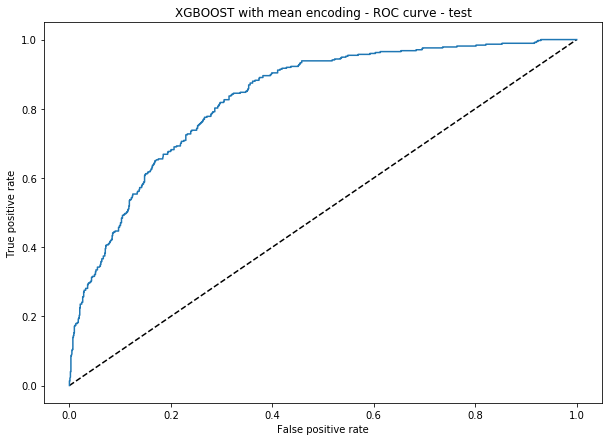

AUC score:  0.8317294003758328
Precision:  0.49059561128526646
Recall:  0.8368983957219251
Accuracy:  0.7256574271499645
F1 score:  0.6185770750988142


Confusion Matrix:


Predicted     
                 0    1
Actual 0       708  325
       1        61  313



Classification report:

               precision    recall  f1-score   support

           0       0.92      0.69      0.79      1033
           1       0.49      0.84      0.62       374

    accuracy                           0.73      1407
   macro avg       0.71      0.76      0.70      1407
weighted avg       0.81      0.73      0.74      1407



In [202]:
best_model_mean.fit(train2_x,train2_y)
y_prob = [train2_y for train2_x,train2_y in best_model_mean.predict_proba(test2_x)]
metrics_ROC(best_model_mean, test2_x, 'XGBOOST with mean encoding',  test2_y, y_prob)

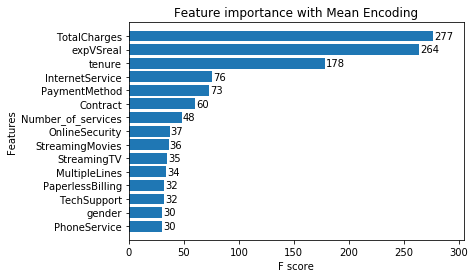

In [203]:
# this value is the number of times a feature appears in a tree
from xgboost import plot_importance
plot_importance(best_model_mean,
                max_num_features = 15,
                height = 0.8,
                grid = False,
                title = 'Feature importance with Mean Encoding')
plt.show()

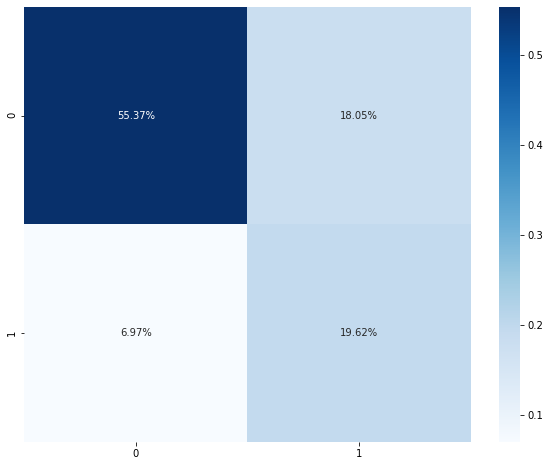

In [198]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
predizioni_best = best_model_mean.predict(test2_x)
plt.figure(figsize = (10,8))
cm = confusion_matrix(test2_y, predizioni_best)
sns.heatmap(cm/np.sum(cm), annot=True, 
            fmt='.2%', cmap='Blues')
plt.show()


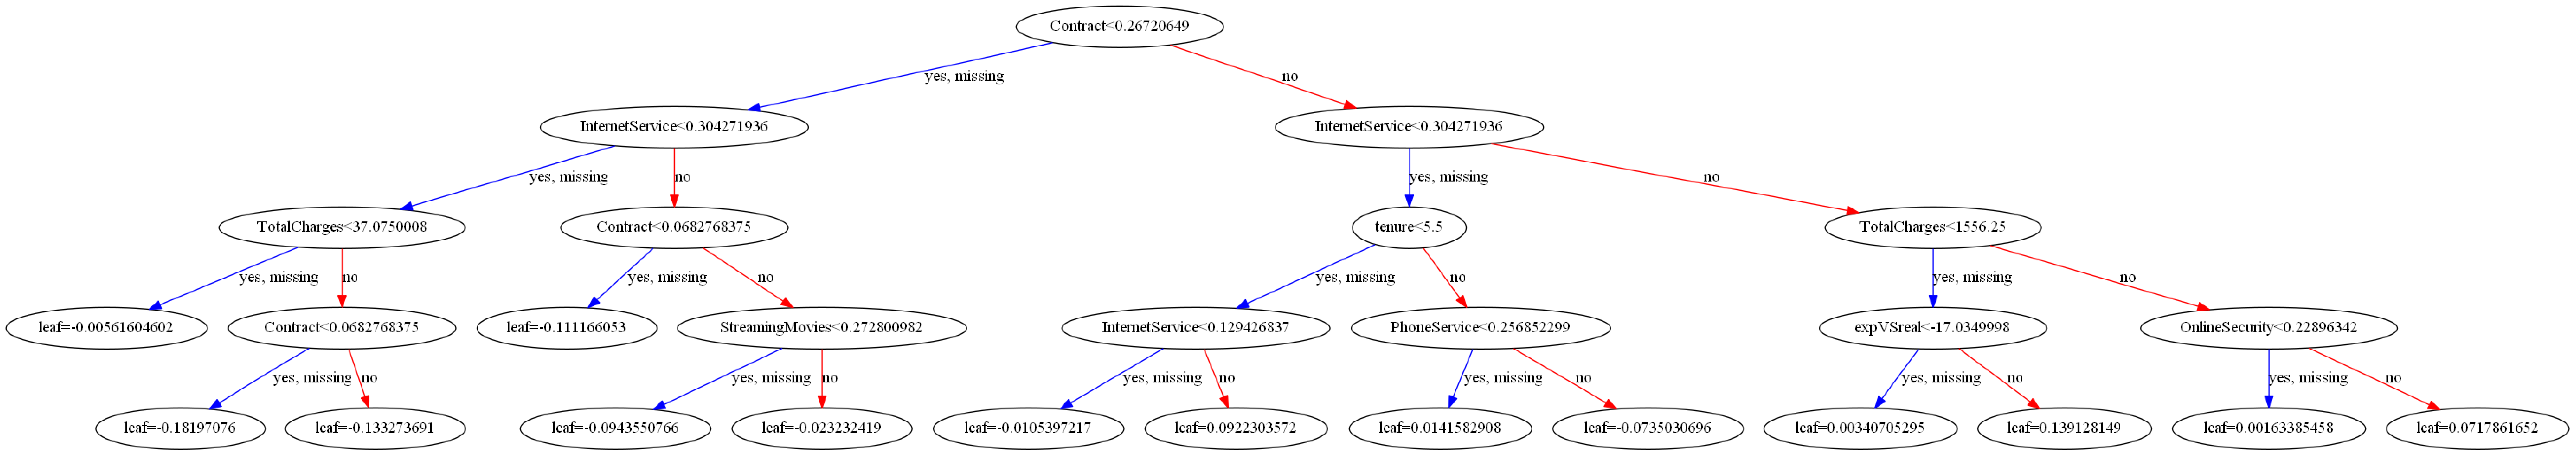

In [199]:
from xgboost import plot_tree
import graphviz
import os
os.environ["PATH"] += os.pathsep + 'C:/Program Files (x86)/Graphviz2.38/bin/'

plot_tree(best_model_mean, num_trees = 0)
fig = plt.gcf()
fig.set_size_inches(200, 400)

In [1]:
git init

SyntaxError: invalid syntax (<ipython-input-1-f188d5ac1197>, line 1)